In [45]:

# Read in previously generated data
def retrieve_subframes():
    '''
    Gets partitioned dataframes from source
    :return: list of dataframes
    '''
    subframes = []
    for i in range(0, 8):
        subframes.append(pd.read_csv('../data_inspection/generated_and_cleaned/it_' + str(i) + '.csv'))
    return subframes

In [46]:
def drop_unnamed(subframes):
    for df in subframes:
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
    return subframes

In [47]:
def create_all_sentence_set(merged_df):
    df = pd.DataFrame()
    df['text'] = pd.concat([merged_df['question'], merged_df['answers']], ignore_index=True)

    # Add 'is_question' column
    df['is_question'] = [1] * len(merged_df['question']) + [0] * len(merged_df['answers'])
    return df


In [48]:
from nltk import word_tokenize
## Stemmer
# Tokenization and stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()


def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [49]:
def get_train_test(df):
    # reset index, create train + Test splits
    df.reset_index(drop=True, inplace=True)
    return train_test_split(df['text'], df['is_question'], test_size=0.2, random_state=7)

In [50]:
def halve_df(a_df):
    midpoint = len(a_df) // 2
    subframes = [a_df.iloc[i * midpoint: (i + 1) * midpoint] for i in range(2)]
    return subframes

In [51]:
def offest_df(incorrect):
    # Get last value
    final_val = incorrect['answers'].iloc[-1]
    print(final_val)

    # Shift values in the 'y' column down by one row
    incorrect['answers'] = incorrect['answers'].shift(1)

    # Replace the last value of 'y' at position 0
    incorrect.iloc[0, incorrect.columns.get_loc('answers')] = final_val
    return incorrect

In [52]:
def create_corpus(correct, incorrect):
    corpus = pd.DataFrame()
    corpus['text'] = pd.concat([correct['question'], correct['answers'], incorrect['question'], incorrect['answers']],
                               ignore_index=True)
    corpus.reset_index(drop=True, inplace=True)
    return corpus

In [53]:
def find_reference_index(str_val, corpus):
    for index, row in corpus.iterrows():
        if row['text'] == str_val:
            return index
    return -1

In [54]:
def calculate_cosign_similarity(index_a, index_b, sim_matrix):
    return sim_matrix[index_a, index_b]

In [55]:
import pandas as pd

# Read in previously generated data
subframes = retrieve_subframes()

In [56]:
# For each of these dataframes, drop the 'Unnamed: 0' column if it exists
# Drop the 'Unnamed: 0' column if it exists
subframes = drop_unnamed(subframes)

In [57]:
# Concatenate all DataFrames vertically
merged_df = pd.concat(subframes, ignore_index=True)

In [58]:
merged_df

,question,answers
0,who was the trump ocean club international hot...,the trump ocean club international hotel and t...
1,where was sasha vujačić born,sasha vujačić was born in maribor slovenia
2,what is a region that dead combo was released in,dead combo was released in portugal
3,what is a film directed by wiebke von carolsfeld,marion bridge
4,what country was music for stock exchange rel...,the united states
...,...,...
3995,what horror films came out in 2002,the ring and 28 days later were popular horror...
3996,what language is with the angels composed in,the language of the angels is composed in cele...
3997,what is the release typ eof the album get in t...,the release type of the album get in the ring ...
3998,what is a commune in the country of italy,a commune in italy is a basic local administra...


In [59]:
# Split in half
subframes = halve_df(merged_df)

In [60]:

correct = subframes[0]
incorrect = subframes[1]

In [61]:
incorrect.columns

Index(['question', 'answers'], dtype='object')

In [62]:
# Offset answers to create incorrect pairings
incorrect = offest_df(incorrect)

fred johnson was born in houston texas


C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3507489817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['answers'] = incorrect['answers'].shift(1)


In [63]:
# validate
incorrect

,question,answers
2000,what albums were released in 2000,fred johnson was born in houston texas
2001,which time zone is mifflin part of,kid a by radiohead and stankonia by outkast we...
2002,what is the active ingredient in the drug povi...,mifflin is in the eastern time zone
2003,what is a broadcast station where los lobos is...,the active ingredient in the drug povidoneiodi...
2004,what can be found in houghton county michigan,a radio station that plays los lobos
...,...,...
3995,what horror films came out in 2002,senorita by shawn mendes and camila cabello
3996,what language is with the angels composed in,the ring and 28 days later were popular horror...
3997,what is the release typ eof the album get in t...,the language of the angels is composed in cele...
3998,what is a commune in the country of italy,the release type of the album get in the ring ...


In [64]:
# Set target values
correct['is_pair'] = [1] * len(correct)
incorrect['is_pair'] = 0 * len(incorrect)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3542805647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct['is_pair'] = [1] * len(correct)
C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3542805647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['is_pair'] = 0 * len(incorrect)


In [65]:
correct

,question,answers,is_pair
0,who was the trump ocean club international hot...,the trump ocean club international hotel and t...,1
1,where was sasha vujačić born,sasha vujačić was born in maribor slovenia,1
2,what is a region that dead combo was released in,dead combo was released in portugal,1
3,what is a film directed by wiebke von carolsfeld,marion bridge,1
4,what country was music for stock exchange rel...,the united states,1
...,...,...,...
1995,what is sebastian knights nationality,sebastian knights nationality is russian,1
1996,who founded synopsys,a avantikadapalayam and aart de geus founded s...,1
1997,what is daniel domachowskis profession,daniel domachowski is a physicist,1
1998,who is bill oddies daughter,bill oddies daughter is named rosie oddie,1


In [66]:
incorrect

,question,answers,is_pair
2000,what albums were released in 2000,fred johnson was born in houston texas,0
2001,which time zone is mifflin part of,kid a by radiohead and stankonia by outkast we...,0
2002,what is the active ingredient in the drug povi...,mifflin is in the eastern time zone,0
2003,what is a broadcast station where los lobos is...,the active ingredient in the drug povidoneiodi...,0
2004,what can be found in houghton county michigan,a radio station that plays los lobos,0
...,...,...,...
3995,what horror films came out in 2002,senorita by shawn mendes and camila cabello,0
3996,what language is with the angels composed in,the ring and 28 days later were popular horror...,0
3997,what is the release typ eof the album get in t...,the language of the angels is composed in cele...,0
3998,what is a commune in the country of italy,the release type of the album get in the ring ...,0


In [67]:
# Get Stop Words
from nltk.corpus import stopwords
stop_ = stopwords.words('english')

In [68]:
correct

,question,answers,is_pair
0,who was the trump ocean club international hot...,the trump ocean club international hotel and t...,1
1,where was sasha vujačić born,sasha vujačić was born in maribor slovenia,1
2,what is a region that dead combo was released in,dead combo was released in portugal,1
3,what is a film directed by wiebke von carolsfeld,marion bridge,1
4,what country was music for stock exchange rel...,the united states,1
...,...,...,...
1995,what is sebastian knights nationality,sebastian knights nationality is russian,1
1996,who founded synopsys,a avantikadapalayam and aart de geus founded s...,1
1997,what is daniel domachowskis profession,daniel domachowski is a physicist,1
1998,who is bill oddies daughter,bill oddies daughter is named rosie oddie,1


In [69]:
# Create Corpus
corpus = create_corpus(correct, incorrect)

# Create TF-IDF Matrix

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorize
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_stem)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus['text'])

C:\Users\Cam\PycharmProjects\QARoute\venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [71]:
def find_reference_index(str_val):
    for index, row in corpus.iterrows():
        if row['text'] == str_val:
            return index
    return -1

In [72]:
correct['question_matrix_index'] = correct['question'].apply(find_reference_index)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3521320651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct['question_matrix_index'] = correct['question'].apply(find_reference_index)


In [73]:
correct['answer_matrix_index'] = correct['answers'].apply(find_reference_index)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3406456683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct['answer_matrix_index'] = correct['answers'].apply(find_reference_index)


In [74]:
correct

,question,answers,is_pair,question_matrix_index,answer_matrix_index
0,who was the trump ocean club international hot...,the trump ocean club international hotel and t...,1,0,2000
1,where was sasha vujačić born,sasha vujačić was born in maribor slovenia,1,1,2001
2,what is a region that dead combo was released in,dead combo was released in portugal,1,2,2002
3,what is a film directed by wiebke von carolsfeld,marion bridge,1,3,2003
4,what country was music for stock exchange rel...,the united states,1,4,2004
...,...,...,...,...,...
1995,what is sebastian knights nationality,sebastian knights nationality is russian,1,1995,3995
1996,who founded synopsys,a avantikadapalayam and aart de geus founded s...,1,1996,3996
1997,what is daniel domachowskis profession,daniel domachowski is a physicist,1,1997,3997
1998,who is bill oddies daughter,bill oddies daughter is named rosie oddie,1,1998,3998


In [75]:
incorrect['answer_matrix_index'] = incorrect['answers'].apply(find_reference_index)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\331219049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['answer_matrix_index'] = incorrect['answers'].apply(find_reference_index)


In [76]:
incorrect['question_matrix_index'] = incorrect['question'].apply(find_reference_index)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3358026043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['question_matrix_index'] = incorrect['question'].apply(find_reference_index)


In [77]:
# Now that I have indexes, compare tf_idf
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [78]:
# Calculate cosign similarities across correct frame
correct['similarity'] = correct.apply(lambda row: calculate_cosign_similarity(row['question_matrix_index'], row['answer_matrix_index'], sim_matrix), axis=1)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\3798136410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct['similarity'] = correct.apply(lambda row: calculate_cosign_similarity(row['question_matrix_index'], row['answer_matrix_index'], sim_matrix), axis=1)


In [79]:
incorrect['similarity'] = incorrect.apply(lambda row: calculate_cosign_similarity(row['question_matrix_index'], row['answer_matrix_index'], sim_matrix), axis=1)

C:\Users\Cam\AppData\Local\Temp\ipykernel_15732\2816194546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['similarity'] = incorrect.apply(lambda row: calculate_cosign_similarity(row['question_matrix_index'], row['answer_matrix_index'], sim_matrix), axis=1)


In [80]:
# validate column imputation
correct.columns

Index(['question', 'answers', 'is_pair', 'question_matrix_index',
       'answer_matrix_index', 'similarity'],
      dtype='object')

In [81]:
# Validate column imputation
incorrect.columns

Index(['question', 'answers', 'is_pair', 'answer_matrix_index',
       'question_matrix_index', 'similarity'],
      dtype='object')

In [82]:
# EDA
correct['similarity'].describe()

count    2000.000000
mean        0.500824
std         0.310374
min         0.000000
25%         0.249718
50%         0.602006
75%         0.746086
max         0.966790
Name: similarity, dtype: float64

In [83]:
# More EDA
incorrect['similarity'].describe()

count    2000.000000
mean        0.014309
std         0.027916
min         0.000000
25%         0.000000
50%         0.000000
75%         0.017735
max         0.390301
Name: similarity, dtype: float64

In [84]:
## There is a significant difference in cosine similarity between correct and incorrect pairings
# This is probably good?

In [85]:
# Rename columns and concatenate frames
model_correct = correct[['question', 'answers', 'is_pair', 'similarity']]
model_incorrect = incorrect[['question', 'answers', 'is_pair', 'similarity']]

model_df = pd.concat([model_correct, model_incorrect], ignore_index=True)

In [86]:
# Shuffle dataframe and reset index
model_df= model_df.sample(frac=1, random_state=7)
model_df.reset_index(drop=True, inplace=True)
model_df

,question,answers,is_pair,similarity
0,what is the key element used in eczema treatment,i dont have that information,0,0.000000
1,what is a public school in rigby idaho,a public school in rigby idaho is rigby high s...,1,0.908614
2,what is jeanchristophe sanchezs profession,jeanchristophe sanchez is a professional chef,1,0.669353
3,whats the active ingredient in menthol methyl ...,the music for the film italian for beginners w...,0,0.016729
4,who is clara harris parent,clara harriss parents are vic and becky mcleod,1,0.383299
...,...,...,...,...
3995,what is the genre of the album faithful,the genre of the album faithful is poprock,1,0.732963
3996,what type of album is the album milestones,natalia castellanos was born in mexico city,0,0.000000
3997,what company published the game bejeweled 2 de...,popcap games,1,0.137448
3998,what country is john viener a citizen of,john viener is a citizen of the united states,1,0.825588


In [87]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(model_df[['similarity']], model_df['is_pair'], test_size=0.2, random_state=7)

In [88]:
from sklearn.linear_model import LogisticRegression

# create and train the model
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

LogisticRegression()

In [89]:
# Predictions
y_pred_lr = lr_classifier.predict(X_test)

In [90]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluation
print("TF-IDF + Logistic Regression Classifier Question Answer Pairs with Tokenization and Stemming:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

TF-IDF + Logistic Regression Classifier Question Answer Pairs with Tokenization and Stemming:
Accuracy: 0.89875
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       406
           1       0.99      0.80      0.89       394

    accuracy                           0.90       800
   macro avg       0.91      0.90      0.90       800
weighted avg       0.91      0.90      0.90       800


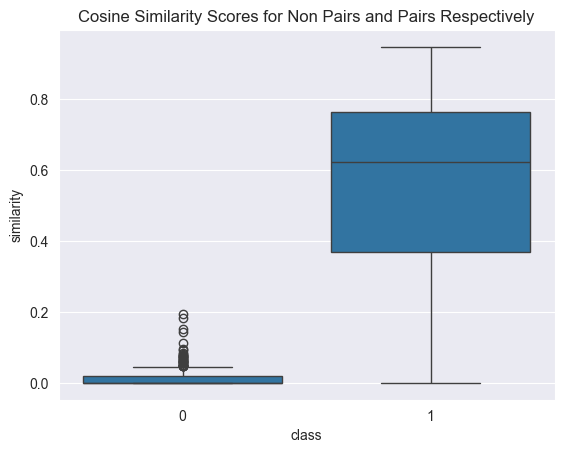

In [91]:
# Plot cosine similarity distributions for test set
import matplotlib.pyplot as plt
import seaborn as sns
box_df = X_test.copy()
box_df['class'] = y_test
sns.boxplot(data=box_df, x='class', y='similarity')
plt.title('Cosine Similarity Scores for Non Pairs and Pairs Respectively')
plt.show()


In [92]:
# Error analysis

In [93]:
predicted_proba = lr_classifier.predict_proba(X_test)

In [94]:
prob_df = pd.DataFrame(predicted_proba)
prob_df.columns

RangeIndex(start=0, stop=2, step=1)

In [95]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_test, prob_df[1])

In [96]:
brier_score

0.08646134580040499

In [98]:
import joblib

joblib.dump(lr_classifier, '../models/pair_model.pkl')
joblib.dump(tfidf_vectorizer, '../models/pair_vectorizer.pkl')

['../models/pair_vectorizer.pkl']